In [13]:

import sys
import os
import random
import glob
import torch
import pandas as pd
sys.path.append("C:/Users/yuuta/Documents/fashion")
from utils.util import filter_basic_items, open_json
from utils.util import is_target_category
from utils.util import calculate_euclid_sum
# from utils.infer import id_to_vector
from utils.util import calc_roc_auc

In [14]:
import importlib
import utils
importlib.reload(utils.util)

<module 'utils.util' from 'C:\\Users/yuuta/Documents/fashion\\utils\\util.py'>

In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # GPUデバイスを取得
else:
    device = torch.device("cpu")  # CPUデバイスを取得

In [17]:
negative_path = glob.glob(
    # "C:/Users/yuuta/Documents/fashion/model_learning/compatibility/data/negative_coordinates/**.json"
    "C:/Users/yuuta/Documents/fashion/model_learning/compatibility/data/negative_coordinates_random/**.json"
    # "C:/Users/yuuta/Documents/fashion/data/test/**/*.json"
    # negative_coordinates_random
)
positive_path = glob.glob(
    "C:/Users/yuuta/Documents/fashion/data/test/**/*.json"
)
negative_path = random.sample(negative_path, 10000)
positive_path = random.sample(positive_path, 20000)

In [18]:
print(len(negative_path), len(positive_path))

10000 20000


In [19]:
id_to_vector = open_json('C:/Users/yuuta/Documents/fashion/model_learning/compatibility/data/id_to_vector.json')

In [20]:

labels = []
proposal_score = []
positive_ave = 0
negative_ave = 0

In [21]:
from utils.util import calculate_euclid_max
p_cnt = 0
for fp in positive_path:
    json_dict = open_json(fp)
    items = filter_basic_items(json_dict["items"])
    vectors = []
    for item in items:
        try:
            itemId = str(item["itemId"])
        except Exception as e:
            print(fp, " : ", e)
            continue
        vector = id_to_vector[itemId]
        vectors.append(torch.tensor(vector))
    if len(vectors) != 3:
        continue
    ps = calculate_euclid_max(vectors)
    proposal_score.append(ps.to("cpu"))
    p_cnt += 1
    labels.append(0)
    positive_ave += ps
positive_ave /= p_cnt
print(f"positive fin average: {positive_ave}")

positive fin average: 206.2220001220703


In [22]:
n_cnt = 0
for fp in negative_path:
    json_dict = open_json(fp)
    items = filter_basic_items(json_dict["items"])
    vectors = []
    for item in items:
        try:
            itemId = str(item["itemId"]) 
        except Exception as e:
            print(fp, " : ", e)
            continue
        vector = id_to_vector[itemId]
        vectors.append(torch.tensor(vector))
        
    if len(vectors) != 3:
        continue
    # print(len(vectors), vectors[0].shape)
    ps = calculate_euclid_max(vectors)
    proposal_score.append(ps.to("cpu"))
    labels.append(1)
    n_cnt += 1
    negative_ave += ps
negative_ave /= n_cnt

print(positive_ave, negative_ave)

tensor(206.2220) tensor(234.9235)


In [ ]:
print(p_cnt, n_cnt)

9815 10000


In [ ]:
print(len(proposal_score), len(labels))

19815 19815


0.6259595291837249


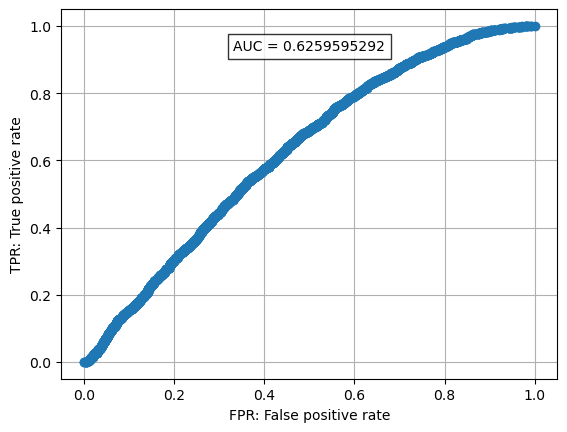

In [24]:
p_auc = calc_roc_auc(labels, proposal_score, "proposal_model_randomly_items")
print(p_auc)